In [1]:
!pip install livelossplot
!pip install webp
from livelossplot.tf_keras import PlotLossesCallback
import webp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 42.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 423 kB 28.5 MB/s 


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, sys
from os import listdir
from os.path import isfile, join
from pathlib import Path
import cv2

from google.colab.patches import cv2_imshow

from tensorflow.keras.applications.resnet import preprocess_input
from glob import glob
from PIL import Image


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def show_predictions(images, labels, predicted_labels=None):
    names = {0: "Tank", 1: "Skirt"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((images[i] + 1)/2., cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

начало

In [2]:
dir_paths = [
    '/content/drive/MyDrive/dir/train_dir/pants/',
    '/content/drive/MyDrive/dir/train_dir/t-shirts/',
    '/content/drive/MyDrive/dir/test_dir/pants/',
    '/content/drive/MyDrive/dir/test_dir/t-shirts/'
]

for dir_path in dir_paths:
  num = 0
  onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]
  for num, filename in enumerate(onlyfiles):
    im = Image.open(Path(dir_path) / filename)
    im = im.save(f'{dir_path}/test{num}.jpg', )




KeyboardInterrupt: ignored

In [3]:
base_dir = Path('/content/drive/MyDrive/dir')
folders = []
test_dir = base_dir / 'test_dir' #в нее кидаем две папки рандомные для теста классов (10 а не 5261)
train_dir = base_dir / 'train_dir'
# train_dir = base_dir / 'train'
# validation_dir = base_dir / 'validation'

# train_cats_dir = train_dir / 'cats'
# train_dogs_dir = train_dir / 'dogs'
# validation_cats_dir = validation_dir / 'cats'
# validation_dogs_dir = validation_dir / 'dogs'


In [ ]:
# os.makedirs('train_dir')
# os.makedirs('test_dir')

конец

In [4]:
class Data():
  def __init__(self):
    pass
  
  def prepare_data(preprocess_input, BATCH_SIZE=1, IMG_SHAPE=150, val_dir=test_dir, train_dir=train_dir, class_mode='binary'):

    # for filename in glob('*.png'):
    #   im = Image.open(filename).convert("RGB")
    #   im.save("test.jpg","jpeg")


    image_gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # указываем preprocessing_function !!!
    image_gen_val = ImageDataGenerator(preprocessing_function=preprocess_input) # указываем preprocessing_function !!!

    BATCH_SIZE = BATCH_SIZE
    IMG_SHAPE  = IMG_SHAPE

    train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                        directory=train_dir,
                                                        shuffle=True,
                                                        target_size=(IMG_SHAPE,IMG_SHAPE),
                                                        class_mode=class_mode)
    
    image_gen_val = ImageDataGenerator(fill_mode='nearest') 

    val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                                  directory=val_dir,
                                                                  shuffle=False,
                                                                  target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                                  class_mode=class_mode)
    return train_data_gen, val_data_gen

In [5]:
data = Data()
train_data_gen, val_data_gen = Data.prepare_data(preprocess_input=preprocess_input, train_dir=train_dir, val_dir=test_dir)


Found 1226 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


In [10]:
class Classifier:
  def __init__(self):
    self.IMG_SHAPE = (150, 150, 3)
    # базовая модель -- MobileNet
    self.base_model = tf.keras.applications.resnet.ResNet101(input_shape=self.IMG_SHAPE, include_top=False)  #, weights='imagenet'
    self.base_model.trainable = False # замораживаем всю базовую модель

  def unfreeze(self):
    self.base_model.trainable = True
    print("Количество слоев в базовой модели: ", len(self.base_model.layers), '\n')
    fine_tune_at = 0
    # все слои до -- заморозим
    for layer in self.base_model.layers[:fine_tune_at]:
      layer.trainable =  False


  def extra_layers(self, loss='binary_crossentropy', metrics='accuracy', optimizer='Adam', num_classes=None): #tf.keras.optimizers.Adam(learning_rate=0.001)
    if num_classes == 2:
      self.model = tf.keras.Sequential([
      self.base_model,
      # tf.keras.layers.Dropout(0.5),
      # tf.keras.layers.BatchNormalization(),
      # tf.keras.layers.Dense(100, activation='elu'),
      # tf.keras.layers.Dropout(0.5),
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])
    else:
      self.model = tf.keras.Sequential([
      self.base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(num_classes, activation='softmax')
      ])
    self.model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

    print('!the model was built with additional layers!\n')
  
  
  def fit_train(self, epochs=10, train_data_gen=train_data_gen, val_data_gen=val_data_gen):      #change valid
    self.hist = self.model.fit_generator(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    )

    print('!The model has been trained!\n')


  def fit_vizualization(self):
    plt.plot(self.hist.history['loss'])
    plt.plot(self.hist.history['val_loss'])


  def predict_classes(self, datagen=val_data_gen):
    sample_validation_images, sample_validation_labels = next(datagen)
    self.predictions = (self.model.predict(sample_validation_images) > 0.5).astype("int32").flatten()
    self.sample_validation_images = sample_validation_images
    self.sample_validation_labels = sample_validation_labels


  def show_predictions(self, images, labels, predicted_labels=None):
    names = {0: "Pant", 1: "T-shirt"}
    plt.figure(figsize=(10,10))
    for i in range(len(predicted_labels)):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((images[i] + 1)/2., cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

In [14]:
%%time
ozon = Classifier()
ozon.extra_layers(num_classes=2)
ozon.unfreeze()
ozon.fit_train(epochs=5)      #change valid


!the model was built with additional layers!

Количество слоев в базовой модели:  345 

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


1226/1226 [==============================] - 34s 23ms/step - loss: 0.2822 - accuracy: 0.9005 - val_loss: 0.1906 - val_accuracy: 0.9259
Epoch 2/5
1226/1226 [==============================] - 27s 22ms/step - loss: 0.1468 - accuracy: 0.9511 - val_loss: 0.2328 - val_accuracy: 0.9352
Epoch 3/5
1226/1226 [==============================] - 27s 22ms/step - loss: 0.0962 - accuracy: 0.9608 - val_loss: 0.2140 - val_accuracy: 0.9074
Epoch 4/5
1226/1226 [==============================] - 28s 23ms/step - loss: 0.0901 - accuracy: 0.9698 - val_loss: 0.2458 - val_accuracy: 0.8889
Epoch 5/5
1226/1226 [==============================] - 27s 22ms/step - loss: 0.0739 - accuracy: 0.9796 - val_loss: 0.1595 - val_accuracy: 0.9167
!The model has been trained!

CPU times: user 2min 31s, sys: 5.39 s, total: 2min 37s
Wall time: 2min 25s


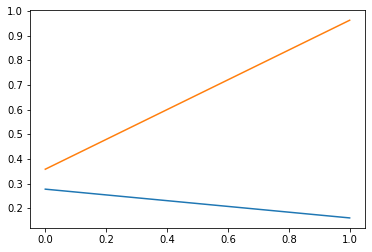

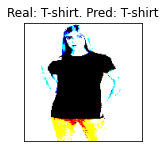

In [12]:
ozon.fit_vizualization()
ozon.predict_classes(train_data_gen)    #change valid
ozon.show_predictions(ozon.sample_validation_images, ozon.sample_validation_labels, ozon.predictions)

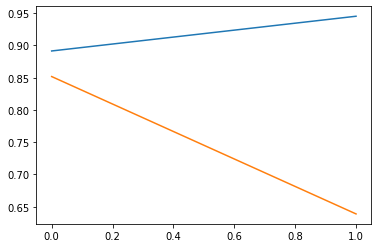

In [13]:
plt.plot(ozon.hist.history['accuracy'])
plt.plot(ozon.hist.history['val_accuracy'])